In [118]:
import pandas as pd
from pandas import concat
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import argrelextrema
from sklearn.metrics import confusion_matrix

In [119]:
class AutoRF():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    self.model: record a CNN trained model
    self.train_result: record model fit result loss
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    
    
    
    
    def __init__(self, data_name, target_name, drop_cols=['Date']):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, index_col=0)
        
        #drop columns and na
        data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        # data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data = data
 
        self.n = 0
        self.df_result = 0
        self.lag = 0
        self.rmse = 0
        self.target = target_name
        self.n_features = len(data.columns) - 1
        self.model = 0
        self.train_result = 0

    def preprocess(self, dataset):
        ilocs_min = argrelextrema(dataset['SP500-EPS-Index'].values, np.less_equal, mode = 'wrap', order = 12)[0]
        ilocs_max = argrelextrema(dataset['SP500-EPS-Index'].values, np.greater_equal, mode = 'wrap', order = 12)[0]
        
        # encode expanding period as 1, contracting period as 0
        is_expanding = []
        i = 0
        is_expanding.extend(np.repeat(0, ilocs_min[i]))

        while i < len(ilocs_min) - 1:
            num_expanding = ilocs_max[i] - ilocs_min[i]
            num_contracting = ilocs_min[i + 1] - ilocs_max[i]
            is_expanding.extend(np.repeat(1, num_expanding))
            is_expanding.extend(np.repeat(0, num_contracting))
            i += 1

        is_expanding.extend(np.repeat(1, ilocs_max[i] - ilocs_min[i]))
        is_expanding.extend(np.repeat(0, dataset.shape[0] - ilocs_max[i]))
        dataset.insert(0, 'IsExpanding', is_expanding)
        return dataset
    
    def print_date_range(self):
        #Print Range of Date column
        print('Date Range: ', self.data_backup['Date'].iloc[0], '--', self.data_backup['Date'].iloc[-1])
    
    # convert series to supervised learning
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    

    def run(self, pred_begin_date, n, lags=3): 
        ''' Run CNN
        
        Params
        ----------
        pred_begin_date: date, the begin date of prediction
        n: int, length of prediction (unit in months)      
        lag: int, num of past months to consider
        if_target: boolean, whether to include target as a predictor
        '''
        self.data = self.preprocess(self.data)
        self.data.drop('SP500-EPS-Index', axis=1, inplace=True)
        self.data.dropna(inplace = True)

        # flatten data
        reframed = self.series_to_supervised(self.data, lags, 1)
        # drop columns we don't want to predict
        reframed.drop(reframed.columns[range(reframed.shape[1] - self.n_features, reframed.shape[1])], axis=1, inplace=True)
        
        values = reframed.values
        self.n = n

        test_date_begin = self.data.index.get_loc(pred_begin_date) - lags
    
        train = values[:test_date_begin, :]
        test = values[test_date_begin: test_date_begin+self.n, :]


        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        #train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        # create and fit the LSTM network
        model = RandomForestClassifier(max_depth=2, random_state=0)
        
        result = model.fit(train_X, train_y)
        self.model = model
        self.train_result = result
        
        pred_y = self.model.predict(test_X)
        
        # reverse standardization
        #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

        # invert scaling for forecast
        #test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        pred_y = pred_y.reshape((len(pred_y), 1))
        
        # invert scaling for actual

        test_y = test_y.reshape((len(test_y), 1))

        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(pred_y, test_y))
        print('Test RMSE: %.3f' % rmse)


        df_result = pd.DataFrame(pred_y, columns=[self.target + '_pred'])
        df_result[self.target] = pred_y

        ### TODO modify range

        df_result['Date'] = self.data.index[test_date_begin + lags:  test_date_begin+lags+n]
        df_result.set_index(['Date'],inplace=True)

        self.df_result = df_result
        self.rmse = round(rmse,2)

(343, 12) (343,) (120, 12) (120,)
Test RMSE: 0.204


<AxesSubplot:xlabel='Date'>

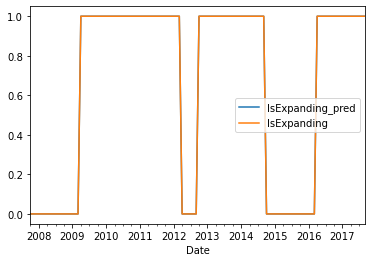

In [128]:
rf_model = AutoRF(data_name='merged_data_1020.xlsx', target_name='IsExpanding', drop_cols=['SP500-Price','gdp','ManufacturingNewOrders','ConstructionSpending','GS10'])
d = '2007-10-01 00:00:00'
n = 120
l = 1
rf_model.run(pred_begin_date=d, n=n, lags=l)
rf_model.df_result.plot()

In [129]:
confusion_matrix(rf_model.df_result['IsExpanding_pred'], rf_model.df_result['IsExpanding'])

array([[42,  0],
       [ 0, 78]], dtype=int64)